# 03c02 Flow Neighbor MSE

In [ ]:
# default_exp embed
# hide
from nbdev.showdoc import *
import numpy as np
import matplotlib.pyplot as plt
import torch
import FRED
device = torch.device("cuda" if torch.cuda.is_available() else 'mps' if torch.backends.mps.is_available() else "cpu")
%load_ext autoreload
%autoreload 2

In [ ]:
# export
def flow_neighbor_loss(neighbors, embedded_points, embedded_flows):
    row, col = neighbors
    directions = (embedded_points[col] - embedded_points[row])
    flows = embedded_flows[row]
    loss = torch.norm(directions - flows)**2
    return loss

In [ ]:
# export
def contrastive_flow_loss(not_neighbors, embedded_points, embedded_flows):
    row, col = not_neighbors
    directions = (embedded_points[col] - embedded_points[row])
    flows = embedded_flows[row]
    dist_to_flow = torch.norm(directions - flows)**2
    loss = 1/dist_to_flow
    return loss

In [ ]:
# export
from FRED.data_processing import flashlight_cosine_similarity, affinity_matrix_from_pointset_to_pointset, flashlight_kernel
from torch.nn.functional import cross_entropy
def contrastive_flow_loss_V2(
        embedded_points, # a batch of embedded points
        embedded_flows, # the flows associated to each embedded point
        center_point_idxs,
        neighbor_idxs, # a list of size batch_size/2, mapping point i in the batch to its neighbor in the batch, neighbor[i]
        use_distance_kernel = True,
        ): # Could be a list of positive indices
    if use_distance_kernel: # best for high-dimensional embeddings; doesn't work in 2d
        A = flashlight_kernel(embedded_points,embedded_flows,kernel_type='fixed',sigma=0.7)
    else:
        A = flashlight_cosine_similarity(embedded_points, embedded_flows) # produces matrix of affinities
    # get rows of A corresponding to each center point
    affinity_predictions = A[center_point_idxs]
    loss = cross_entropy(affinity_predictions, neighbor_idxs)
    return loss

## Experimental validation
Is the flow contrastive loss minimized when each arrow is pointing to its neighbor?

Here's the loss with the arrows pointing to the direct neighbors:

In [ ]:
batch_size = 16

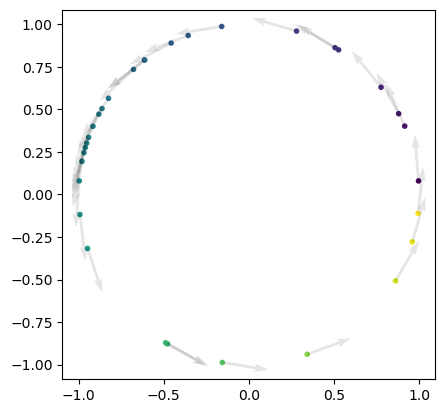

In [ ]:
from FRED.datasets import directed_circle,plot_directed_2d
X, flows, labels = directed_circle(num_nodes=batch_size*2)
X = torch.tensor(X)
flows = torch.tensor(flows)
plot_directed_2d(X,flows,labels,arrow_scale=8,mask_prob=0)

In [ ]:
# two vectors of neighbors
center_point_idxs = torch.arange(0, len(X),step=2)
neighbor_idxs = center_point_idxs + 1
loss = contrastive_flow_loss_V2(X,flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=True)
print("optimal loss is",loss.item())

neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss = contrastive_flow_loss_V2(X,-flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=True)
print("loss with arrows pointing the opposite direction is",loss.item())

flow_p = torch.zeros_like(flows)
flow_p[:,0] = flows[:,1]
flow_p[:,1] = flows[:,0]
flow_p = -flow_p
loss = contrastive_flow_loss_V2(X,flow_p,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=True)
print("loss with arrows perpendicular to points",loss.item())

loss = contrastive_flow_loss_V2(X,flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=False)
print("optimal loss without distance kernel",loss.item())

loss = contrastive_flow_loss_V2(X,-flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=False)
print("loss with arrows pointing the opposite direction (without distance kernel) is",loss.item())

loss = contrastive_flow_loss_V2(X,flow_p,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=False)
print("loss with arrows perpendicular to points (without distance kernel) is ",loss.item())

optimal loss is 2.920560582543095
loss with arrows pointing the opposite direction is 3.5532339125559775
loss with arrows perpendicular to points 3.287902313538074
optimal loss without distance kernel 2.753813468883819
loss with arrows pointing the opposite direction (without distance kernel) is 4.6318232531969725
loss with arrows perpendicular to points (without distance kernel) is  3.819515979596314


How does this change with a larger batch size?

In [ ]:
batch_size = 64

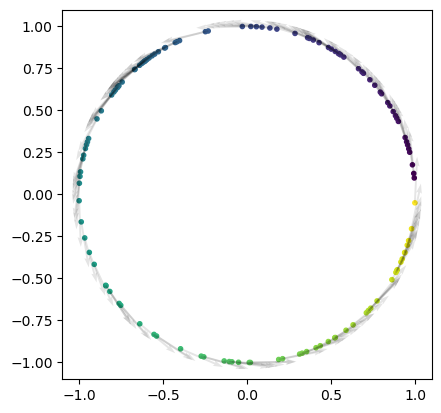

In [ ]:
from FRED.datasets import directed_circle,plot_directed_2d
X, flows, labels = directed_circle(num_nodes=batch_size*2)
X = torch.tensor(X)
flows = torch.tensor(flows)
plot_directed_2d(X,flows,labels,arrow_scale=8,mask_prob=0)

In [ ]:
# two vectors of neighbors
center_point_idxs = torch.arange(0, len(X),step=2)
neighbor_idxs = center_point_idxs + 1
loss = contrastive_flow_loss_V2(X,flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=True)
print("optimal loss is",loss.item())

neighbors = torch.tensor(np.concatenate([np.arange(1,batch_size*2),np.arange(0,1)]))
loss = contrastive_flow_loss_V2(X,-flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=True)
print("loss with arrows pointing the opposite direction is",loss.item())

flow_p = torch.zeros_like(flows)
flow_p[:,0] = flows[:,1]
flow_p[:,1] = flows[:,0]
flow_p = -flow_p
loss = contrastive_flow_loss_V2(X,flow_p,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=True)
print("loss with arrows perpendicular to points",loss.item())

loss = contrastive_flow_loss_V2(X,flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=False)
print("optimal loss without distance kernel",loss.item())

loss = contrastive_flow_loss_V2(X,-flows,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=False)
print("loss with arrows pointing the opposite direction (without distance kernel) is",loss.item())

loss = contrastive_flow_loss_V2(X,flow_p,center_point_idxs=center_point_idxs, neighbor_idxs=neighbor_idxs,use_distance_kernel=False)
print("loss with arrows perpendicular to points (without distance kernel) is ",loss.item())

optimal loss is 4.077879580845979
loss with arrows pointing the opposite direction is 4.929360192146682
loss with arrows perpendicular to points 4.531409463082195
optimal loss without distance kernel 4.139366916281914
loss with arrows pointing the opposite direction (without distance kernel) is 6.030003592864749
loss with arrows perpendicular to points (without distance kernel) is  5.071717175149312


Even with very large batch sizes, the optimal loss is the lowest. The problem then seems to be that gradient information is not flowing through the loss function to the flow artist.